In [3]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [4]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [7]:
openai = OpenAI()
claude = Anthropic()

In [8]:
%matplotlib inline

In [11]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [12]:
# Write the test set to a CSV


import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [13]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [14]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $65.99 Error: $54.01 SLE: 0.35 Item: Setpower Insulated Protective Cover for ...
2: Guess: $80.00 Truth: $9.68 Error: $70.32 SLE: 4.10 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $35.00 Truth: $155.98 Error: $120.98 SLE: 2.17 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $350.00 Truth: $5.59 Error: $344.41 SLE: 15.80 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $75.00 Truth: $98.40 Error: $23.40 SLE: 0.07 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $12.00 Truth: $54.99 Error: $42.99 SLE: 2.13 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $115.00 Truth: $5.71 Error: $109.29 SLE: 8.12 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $100.00 Truth: $9.53 Error: $90.47 SLE: 5.11 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $300.00 Truth: $11.24 Error: $288.76 SLE: 10.26 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $80.00 Truth: $12.88 Error: $67.12 SLE: 3.11 Ite

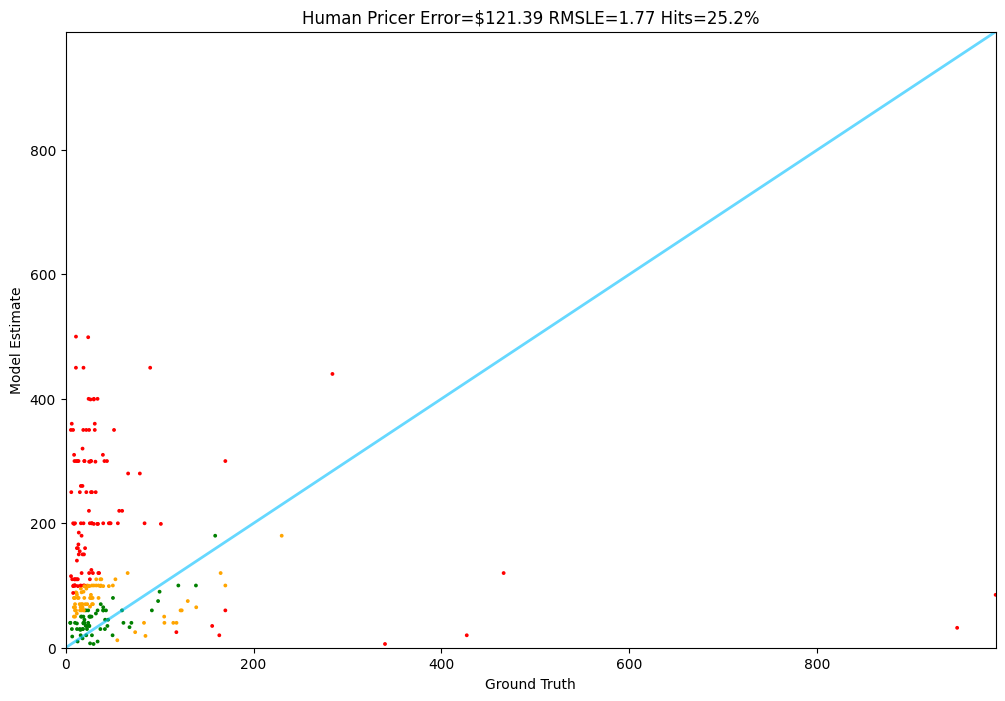

In [15]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [19]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [20]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [21]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [22]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [23]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [24]:
test[0].price

65.99

1: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 Item: Setpower Insulated Protective Cover for ...
2: Guess: $10.99 Truth: $9.68 Error: $1.31 SLE: 0.01 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $129.99 Truth: $155.98 Error: $25.99 SLE: 0.03 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $15.99 Truth: $5.59 Error: $10.40 SLE: 0.90 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $30.00 Truth: $98.40 Error: $68.40 SLE: 1.36 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $35.99 Truth: $54.99 Error: $19.00 SLE: 0.17 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $10.99 Truth: $5.71 Error: $5.28 SLE: 0.34 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $10.99 Truth: $9.53 Error: $1.46 SLE: 0.02 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $15.99 Truth: $11.24 Error: $4.75 SLE: 0.11 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $29.99 Truth: $12.88 Error: $17.11 SLE: 0.65 Item: Away NV350 

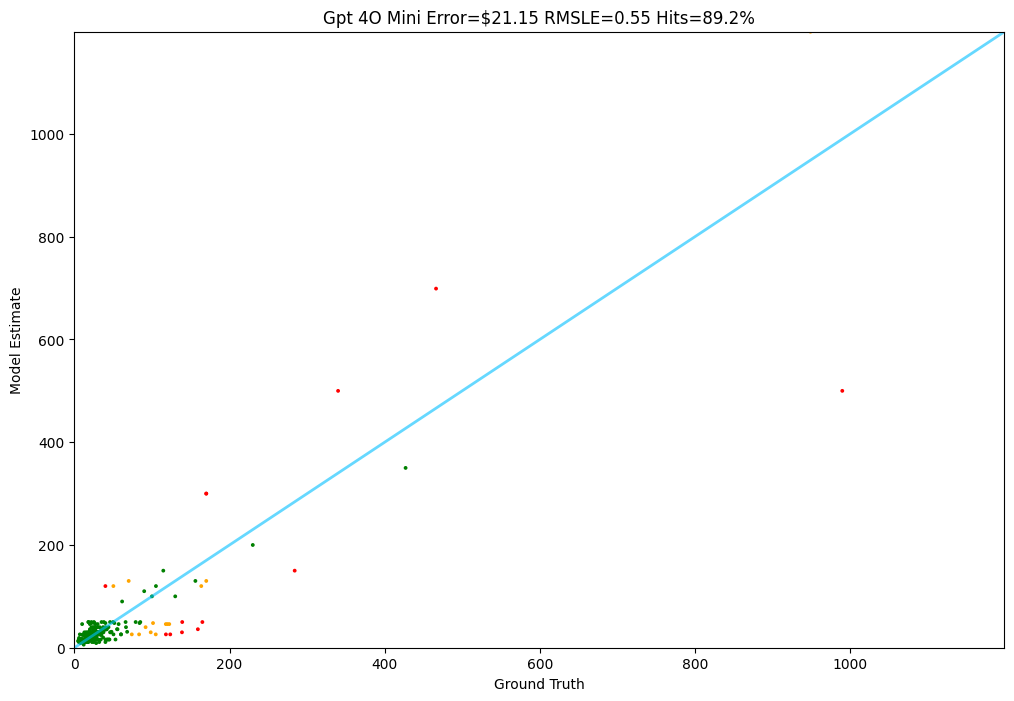

In [25]:
Tester.test(gpt_4o_mini, test)

In [26]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 Item: Setpower Insulated Protective Cover for ...
2: Guess: $10.00 Truth: $9.68 Error: $0.32 SLE: 0.00 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $125.00 Truth: $155.98 Error: $30.98 SLE: 0.05 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $11.99 Truth: $5.59 Error: $6.40 SLE: 0.46 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $35.00 Truth: $98.40 Error: $63.40 SLE: 1.03 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $39.99 Truth: $54.99 Error: $15.00 SLE: 0.10 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $7.99 Truth: $5.71 Error: $2.28 SLE: 0.09 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $10.00 Truth: $9.53 Error: $0.47 SLE: 0.00 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $14.99 Truth: $11.24 Error: $3.75 SLE: 0.07 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $15.00 Truth: $12.88 Error: $2.12 SLE: 0.02 Item: Away NV350 NV3

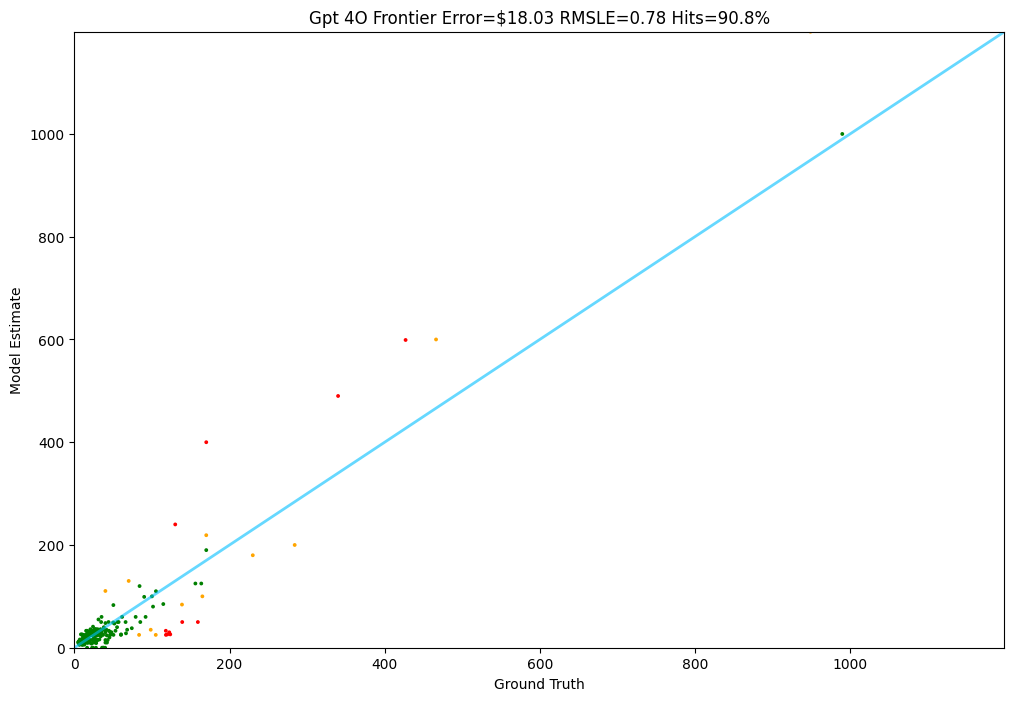

In [27]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)